<a href="https://colab.research.google.com/github/harsh-bat/tensorFlow2Learn/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob
import sys, os


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Getting that data and moving stuff. Same as last script
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip
!unzip -qq -o Food-5K.zip
!mv Food-5K/* .
!mkdir data
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food
train_path = 'data/train'
valid_path = 'data/test'
IMAGE_SIZE = [200, 200]
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')
folders = glob(train_path + '/*')

--2020-09-15 10:17:49--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 172.67.213.166, 104.31.80.48, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  8.81MB/s    in 53s     

2020-09-15 10:18:43 (8.08 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [3]:
ptm = PretrainedModel(
    input_shape = IMAGE_SIZE + [3],
    include_top=False,
    weights = 'imagenet',
)
ptm.trainable = False

58892288/58889256 [==============================] - 2s 0us/step


In [4]:
x = Flatten()(ptm.output)
model = Model(inputs=ptm.input, outputs=x)

In [5]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)      

In [6]:
gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 128


train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
Ntrain = len(image_files)
Nvalid = len(valid_image_files)

# Random image sent to get th shape
feat = model.predict(np.random.random([1] + IMAGE_SIZE + [3]))
D = feat.shape[1]

X_train = np.zeros((Ntrain, D))
Y_train = np.zeros(Ntrain)
X_valid = np.zeros((Nvalid, D))
Y_valid = np.zeros(Nvalid)

In [8]:
i = 0
for x, y in train_generator:
  # get features
  features = model.predict(x)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)
  
  # assign to X_train and Ytrain
  X_train[i:i + sz] = features
  Y_train[i:i + sz] = y
  
  # increment i
  i += sz
  print(i)

  if i >= Ntrain:
    print('breaking now')
    break
print(i)

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3000
breaking now
3000


In [9]:
i = 0
for x, y in valid_generator:
  features = model.predict(x)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)
  
  # assign to X_train and Ytrain
  X_valid[i:i + sz] = features
  Y_valid[i:i + sz] = y
  
  # increment i
  i += sz

  if i >= Nvalid:
    print('breaking now')
    break
print(i)

breaking now
1000


In [10]:
X_train.max(), X_train.min()

(650.8261108398438, 0.0)

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train2 = scaler.fit_transform(X_train)
X_valid2 = scaler.transform(X_valid)

In [17]:
i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)
linearmodel = Model(i, x)

In [18]:
linearmodel.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [19]:
r = linearmodel.fit(
    X_train, Y_train,
    batch_size=128,
    epochs=20,
    validation_data=(X_valid, Y_valid),
)

Epoch 1/20
24/24 [==============================] - 0s 16ms/step - loss: 1.0008 - accuracy: 0.9337 - val_loss: 0.2529 - val_accuracy: 0.9790
Epoch 2/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0811 - accuracy: 0.9930 - val_loss: 0.2830 - val_accuracy: 0.9790
Epoch 3/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0257 - accuracy: 0.9963 - val_loss: 0.3372 - val_accuracy: 0.9740
Epoch 4/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 0.2760 - val_accuracy: 0.9780
Epoch 5/20
24/24 [==============================] - 0s 9ms/step - loss: 8.3600e-04 - accuracy: 0.9997 - val_loss: 0.2875 - val_accuracy: 0.9760
Epoch 6/20
24/24 [==============================] - 0s 9ms/step - loss: 4.5154e-05 - accuracy: 1.0000 - val_loss: 0.3039 - val_accuracy: 0.9780
Epoch 7/20
24/24 [==============================] - 0s 8ms/step - loss: 3.4327e-06 - accuracy: 1.0000 - val_loss: 0.3024 - val_accuracy: 0.9780
Epoch 8

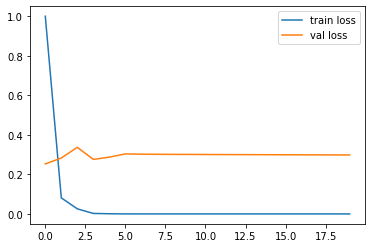

In [20]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

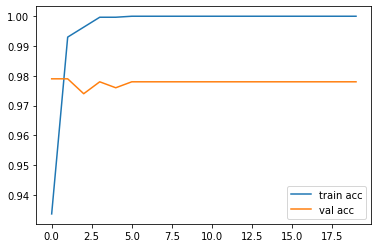

In [21]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()